# Importing Library

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, zipfile, random, shutil, datetime
from google.colab import drive, files
drive.mount('/content/drive')
%matplotlib inline

Mounted at /content/drive


In [ ]:
tf.__version__

'2.17.1'

In [ ]:
target_size = (224, 224)
batch_size = 256
input_shape = (224, 224, 3)

# Download n Extract Dataset

In [ ]:
!kaggle datasets download -d ravyardiankusuma/motif-batik-indonesia-fix

with zipfile.ZipFile("motif-batik-indonesia-fix.zip", "r") as zip_ref:
    zip_ref.extractall("motif-batik-indonesia-fix")

base_dir = "/content/motif-batik-indonesia-fix"

Dataset URL: https://www.kaggle.com/datasets/ravyardiankusuma/motif-batik-indonesia-fix
License(s): ODbL-1.0
100% 2.78G/2.79G [00:26<00:00, 90.7MB/s]
100% 2.79G/2.79G [00:26<00:00, 111MB/s] 


In [ ]:
zip_file = "motif-batik-indonesia-fix.zip"

if os.path.exists(zip_file):
    os.remove(zip_file)
    print(f"The file '{zip_file}' was successfully deleted.")
else:
    print(f"The file '{zip_file}' was not found.")

The file 'motif-batik-indonesia-fix.zip' was successfully deleted.


# Preprocessing the Data into Tabular DataFrame

In [ ]:
data = []

for folder_name in sorted(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):
        try:
            region, motif = folder_name.split("_", 1)
        except ValueError:
            continue

        file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

        data.append([motif, region, file_count])

df = pd.DataFrame(data, columns=["Motif Name", "Region Name", "Number of Photos"])

for col in ["Motif Name", "Region Name"]:
    df[col] = df[col].str.replace(r'([a-z])([A-Z])', r'\1 \2', regex=True)

print(df)

            Motif Name       Region Name  Number of Photos
0               Barong              Bali              1000
1                Merak              Bali              1000
2          Ondel Ondel           Jakarta              1000
3               Tumpal           Jakarta              1000
4          Megamendung        Jawa Barat              1000
5           Asem Arang       Jawa Tengah              1000
6           Asem Sinom       Jawa Tengah              1000
7           Asem Warak       Jawa Tengah              1000
8               Blekok       Jawa Tengah              1000
9         Blekok Warak       Jawa Tengah              1000
10            Cipratan       Jawa Tengah              1000
11  Gambang Semarangan       Jawa Tengah              1000
12         Ikan Kerang       Jawa Tengah              1000
13       Jagung Lombok       Jawa Tengah              1000
14     Jambu Belimbing       Jawa Tengah              1000
15         Jambu Citra       Jawa Tengah              10

# Splitting Dataset into Train, Validation, Test

In [ ]:
output_dir = "/content/dataset"

os.makedirs(output_dir, exist_ok=True)
for split in ['train', 'validation', 'test']:
    split_path = os.path.join(output_dir, split)
    os.makedirs(split_path, exist_ok=True)

motif_folders = os.listdir(base_dir)

for motif_folder in motif_folders:
    motif_path = os.path.join(base_dir, motif_folder)
    images = os.listdir(motif_path)

    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    for split, split_images in zip(['train', 'validation', 'test'], [train_images, val_images, test_images]):
        split_motif_dir = os.path.join(output_dir, split, motif_folder)
        os.makedirs(split_motif_dir, exist_ok=True)

        for image_file in split_images:
            src_image_path = os.path.join(motif_path, image_file)
            dst_image_path = os.path.join(split_motif_dir, image_file)
            shutil.copy(src_image_path, dst_image_path)

print("The dataset was successfully split into train, validation, and test folders!")

The dataset was successfully split into train, validation, and test folders!


In [ ]:
# # Import from gdrive if available dataset.zip at grdive
# base_dir = "/content/drive/My Drive/dataset.zip"

# output_dir = "/content/dataset"

# with zipfile.ZipFile(base_dir, "r") as zip_ref:
#     zip_ref.extractall(output_dir)

In [ ]:
train_count = sum(len(files) for _, _, files in os.walk(os.path.join(output_dir, 'train')))
val_count = sum(len(files) for _, _, files in os.walk(os.path.join(output_dir, 'validation')))
test_count = sum(len(files) for _, _, files in os.walk(os.path.join(output_dir, 'test')))

print(f"Train images: {train_count}, Validation images: {val_count}, Test images: {test_count}")

Train images: 41600, Validation images: 5200, Test images: 5200


In [ ]:
zip_file_name = 'dataset.zip'
shutil.make_archive(zip_file_name.replace('.zip',''), 'zip', '/content/dataset')

print(f"ZIP file successfully created: {zip_file_name}")

print("--------------------------------------------------------------")

destination_path = '/content/drive/My Drive/' + zip_file_name
shutil.move(zip_file_name, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

ZIP file successfully created: dataset.zip
--------------------------------------------------------------
File successfully moved to Google Drive at: /content/drive/My Drive/dataset.zip


# Data Augmentation

In [ ]:
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/validation"
test_dir = "/content/dataset/test"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Data preprocessing is complete and the generator is ready to use!")

Found 41600 images belonging to 52 classes.
Found 5200 images belonging to 52 classes.
Found 5200 images belonging to 52 classes.
Data preprocessing is complete and the generator is ready to use!


# Build Transfer Learning Model Using MobileNetV2

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(test_generator.class_indices), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 52)                  │          13,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,665,076 (10.17 MB)

 Trainable params: 407,092 (1.55 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

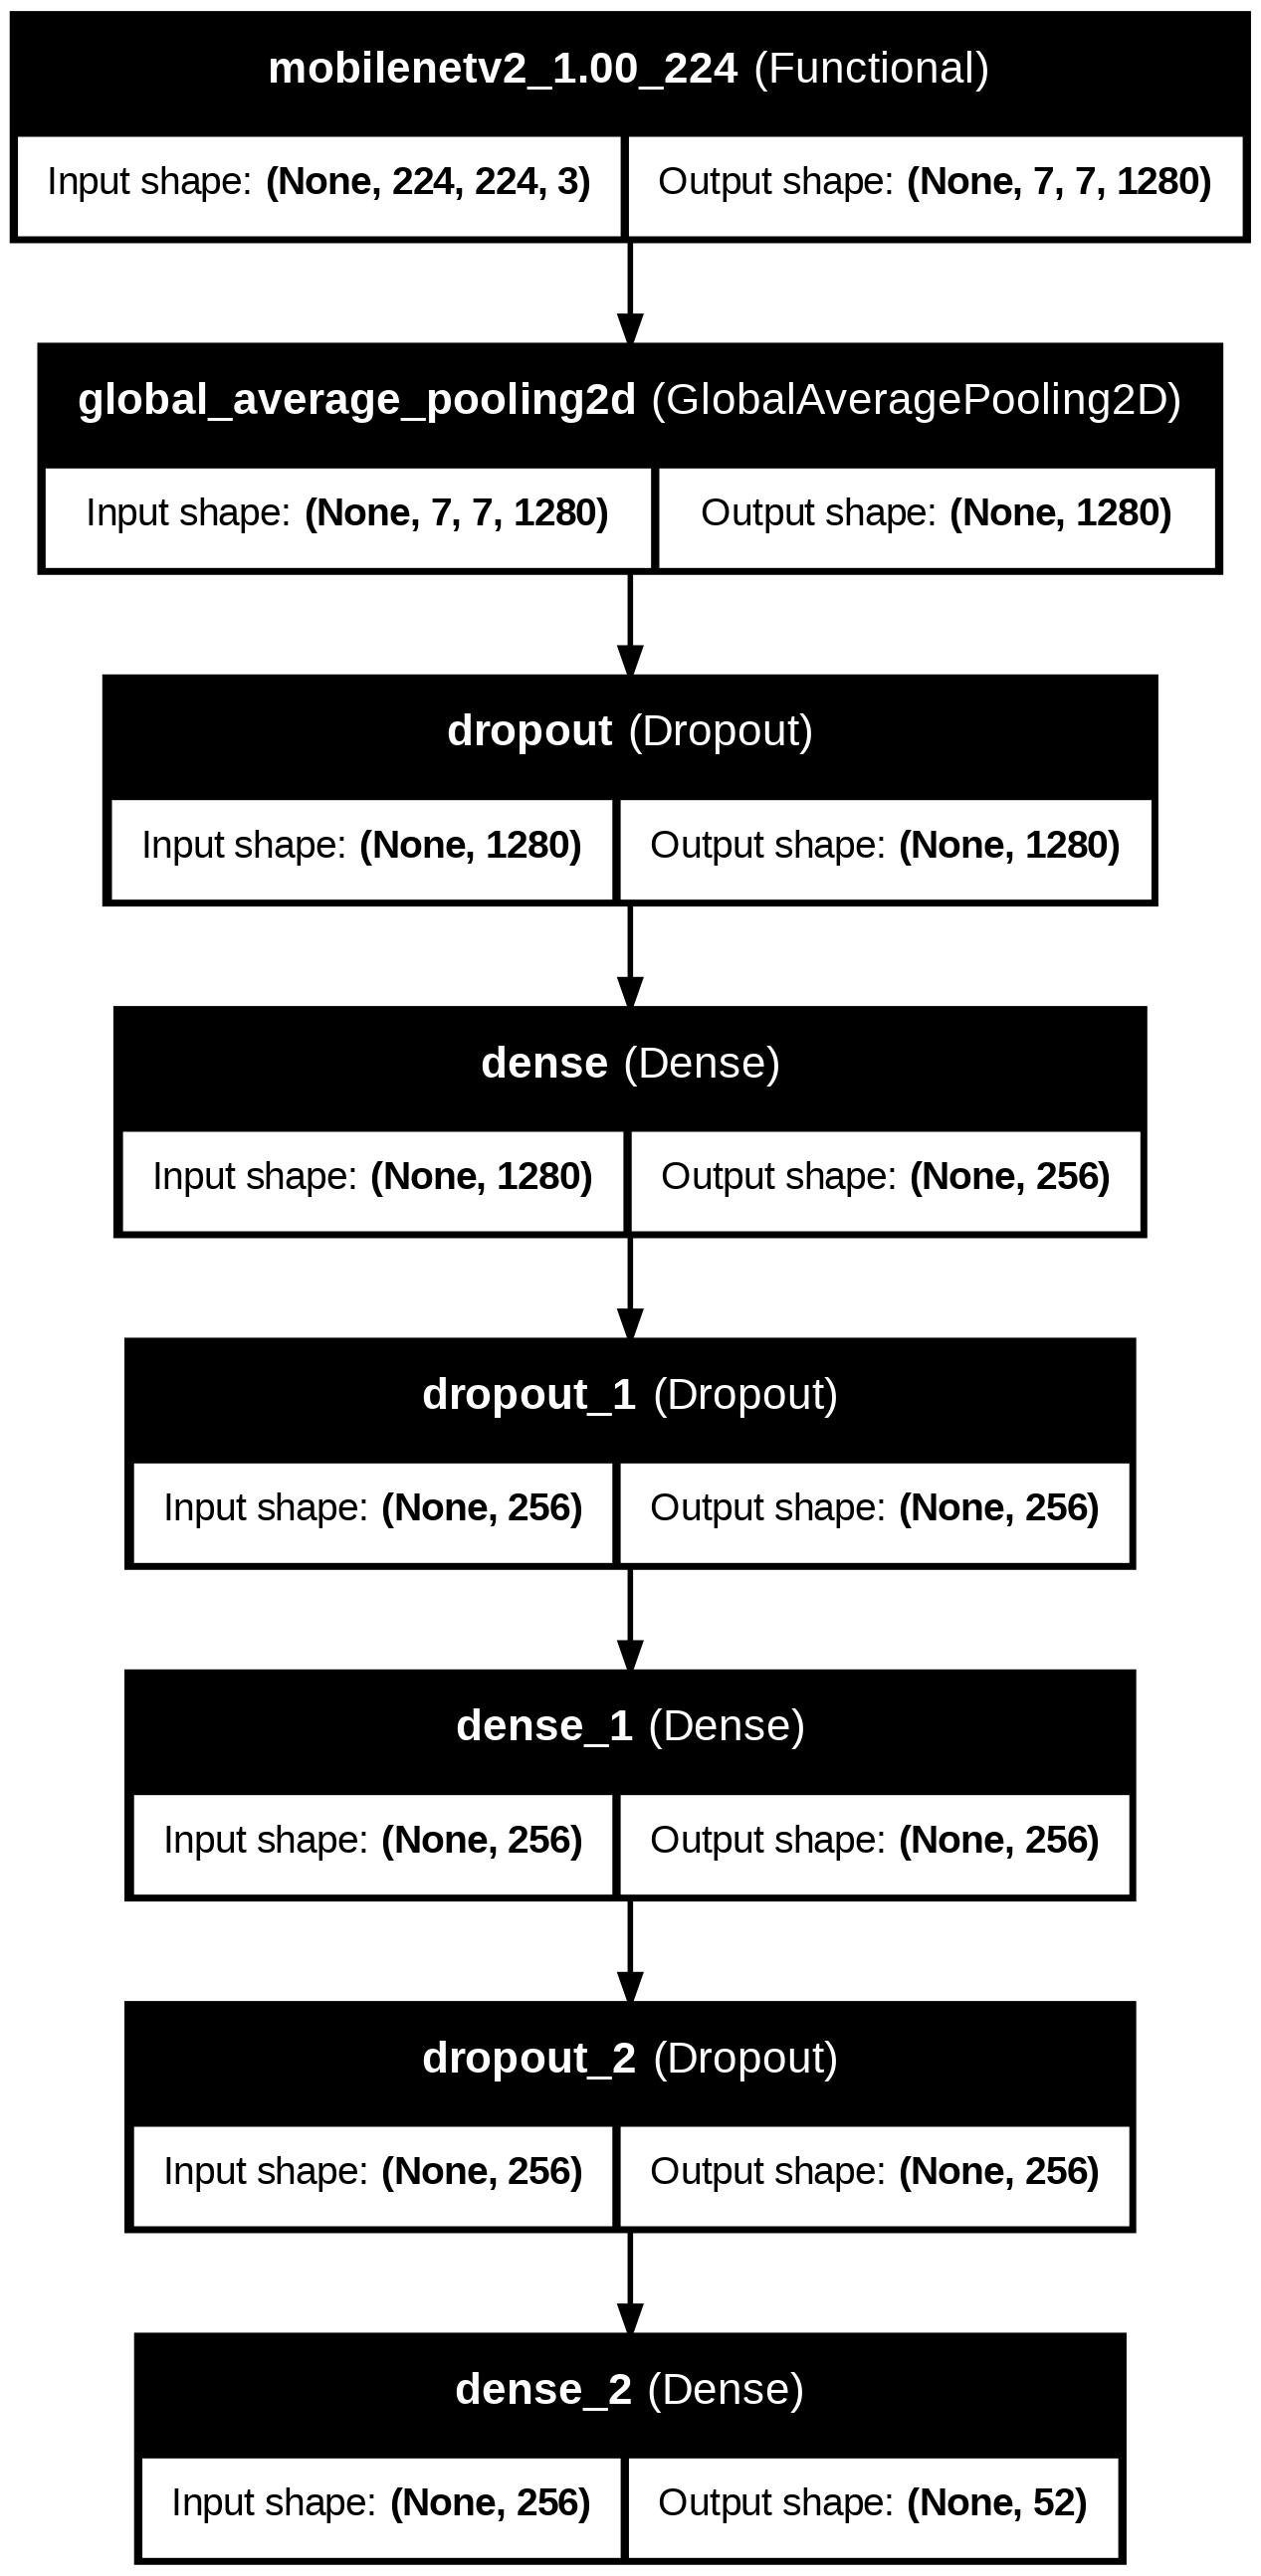

In [ ]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:
file_path = 'model.png'

destination_path = '/content/drive/My Drive/' + file_path
shutil.move(file_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/model.png


# Define Callbacks

In [ ]:
model_checkpoint = ModelCheckpoint(
  'best_mobilenetv2_model.keras',
  monitor='val_loss',
  save_best_only=True,
  mode='min',
  verbose=1
)

csv_logger = CSVLogger(
    'training_log.csv',
    append=True
)

callbacks = [model_checkpoint, csv_logger]

# Training Model

In [ ]:
now = datetime.datetime.now
t = now()
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)
print('Training time: %s' % (now() - t))

model.save('final_mobilenetv2_model.keras')

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3668 - loss: 2.5605
Epoch 1: val_loss improved from inf to 0.41020, saving model to best_xception_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 699s 4s/step - accuracy: 0.3681 - loss: 2.5548 - val_accuracy: 0.8867 - val_loss: 0.4102
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8095 - loss: 0.6507
Epoch 2: val_loss improved from 0.41020 to 0.20274, saving model to best_xception_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 601s 4s/step - accuracy: 0.8096 - loss: 0.6503 - val_accuracy: 0.9429 - val_loss: 0.2027
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8628 - loss: 0.4438
Epoch 3: val_loss improved from 0.20274 to 0.14035, saving model to best_xception_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 634s 4s/step - accuracy: 0.8628 - loss: 0.4436 - val_accuracy: 0.9608 - val_loss: 0.1404
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8951 - loss: 0.3397
Epoch 4: val_loss improved from 0.14035 to

In [ ]:
model_path = 'final_mobilenetv2_model.keras'

destination_path = '/content/drive/My Drive/' + model_path
shutil.move(model_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/final_mobilenetv2_model.keras


In [ ]:
model_path = 'best_mobilenetv2_model.keras'

destination_path = '/content/drive/My Drive/' + model_path
shutil.move(model_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/best_mobilenetv2_model.keras


In [ ]:
model_path = 'training_log.csv'

destination_path = '/content/drive/My Drive/' + model_path
shutil.move(model_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/training_log.csv


# Plot Accuracy and Loss Model

In [ ]:
def plot_learning_curves(epochs, train_acc, val_acc, train_loss, val_loss, file_name):
    x = np.array(epochs)
    x_smooth = np.linspace(x.min(), x.max(), 500)

    train_acc_smooth = make_interp_spline(x, train_acc)(x_smooth)
    val_acc_smooth = make_interp_spline(x, val_acc)(x_smooth)

    train_loss_smooth = make_interp_spline(x, train_loss)(x_smooth)
    val_loss_smooth = make_interp_spline(x, val_loss)(x_smooth)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Accuracy
    axes[0].plot(x_smooth, train_acc_smooth, 'r-', label='Training Accuracy')
    axes[0].plot(x_smooth, val_acc_smooth, 'g-', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy', fontsize=14)
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='best', fontsize=10)
    axes[0].set_ylim((0, 1.05))
    axes[0].grid(True)

    # Plot Loss
    axes[1].plot(x_smooth, train_loss_smooth, 'r-', label='Training Loss')
    axes[1].plot(x_smooth, val_loss_smooth, 'g-', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss', fontsize=14)
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True)

    fig.savefig(file_name)

    plt.tight_layout()
    plt.show()

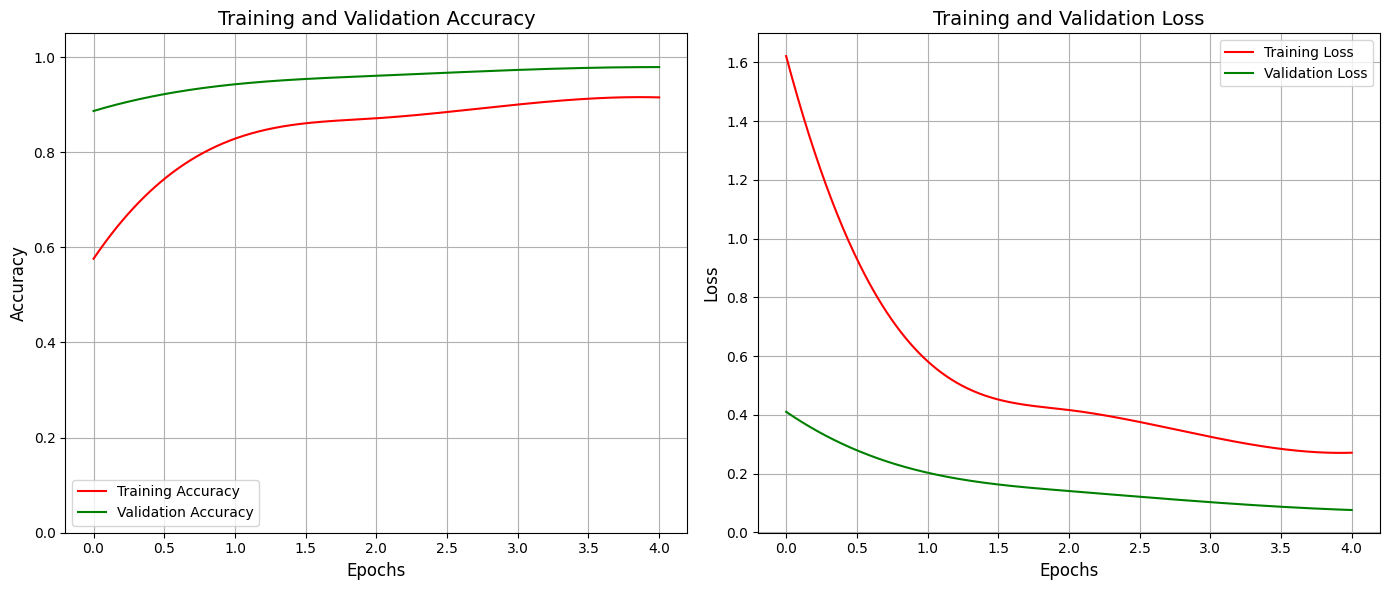

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))

plot_learning_curves(epochs, train_acc, val_acc, train_loss, val_loss, 'MobileNetV2-Accuracy-Loss.png')

In [ ]:
file_path = 'MobileNetV2-Accuracy-Loss.png'

destination_path = '/content/drive/My Drive/' + file_path
shutil.move(file_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/MobileNetV2-Accuracy-Loss.png


# Evaluation Model

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 856ms/step - accuracy: 0.9753 - loss: 0.0860
Validation Loss: 0.0756
Validation Accuracy: 0.9790
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 903ms/step - accuracy: 0.9849 - loss: 0.0599
Test Loss: 0.0702
Test Accuracy: 0.9825


# Predict Test Data

21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 898ms/step


Classification Report

                              precision    recall  f1-score   support

                 Bali_Barong       0.98      1.00      0.99       100
                  Bali_Merak       0.95      1.00      0.98       100
          Jakarta_OndelOndel       0.95      0.97      0.96       100
              Jakarta_Tumpal       0.98      0.97      0.97       100
       JawaBarat_Megamendung       0.98      0.88      0.93       100
        JawaTengah_AsemArang       1.00      1.00      1.00       100
        JawaTengah_AsemSinom       1.00      1.00      1.00       100
        JawaTengah_AsemWarak       0.99      1.00      1.00       100
           JawaTengah_Blekok       1.00      1.00      1.00       100
      JawaTengah_BlekokWarak       1.00      1.00      1.00       100
         JawaTengah_Cipratan       1.00      1.00      1.00       100
JawaTengah_GambangSemarangan       1.00      1.00      1.00       100
       JawaTengah_Ikan

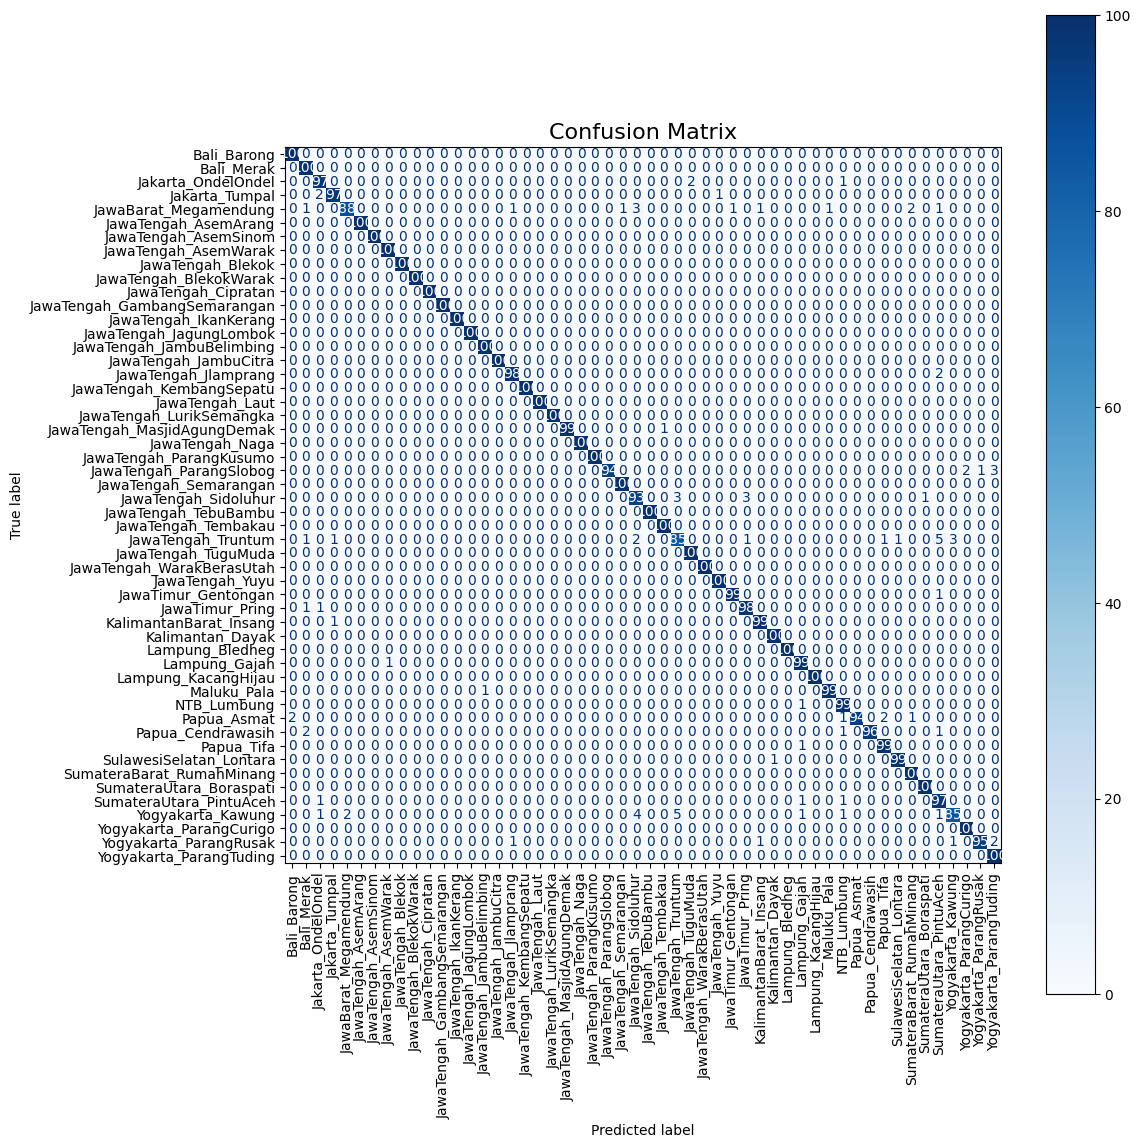

In [ ]:
# Predict
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\n\nClassification Report\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
print("\nConfusion Matrix\n")
cm = confusion_matrix(true_classes, predicted_classes)

# Display Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
disp.ax_.set_title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
correct_per_class = np.diag(cm)
total_per_class = np.sum(cm, axis=1)
incorrect_per_class = total_per_class - correct_per_class
accuracy_per_class = np.round((correct_per_class / total_per_class * 100), 2)

results_df = pd.DataFrame({
    'Category': class_labels,
    'Correct': correct_per_class,
    'Incorrect': incorrect_per_class,
    'Accuracy (%)': accuracy_per_class
})

print(results_df)

                        Category  Correct  Incorrect  Accuracy (%)
0                    Bali_Barong      100          0         100.0
1                     Bali_Merak      100          0         100.0
2             Jakarta_OndelOndel       97          3          97.0
3                 Jakarta_Tumpal       97          3          97.0
4          JawaBarat_Megamendung       88         12          88.0
5           JawaTengah_AsemArang      100          0         100.0
6           JawaTengah_AsemSinom      100          0         100.0
7           JawaTengah_AsemWarak      100          0         100.0
8              JawaTengah_Blekok      100          0         100.0
9         JawaTengah_BlekokWarak      100          0         100.0
10           JawaTengah_Cipratan      100          0         100.0
11  JawaTengah_GambangSemarangan      100          0         100.0
12         JawaTengah_IkanKerang      100          0         100.0
13       JawaTengah_JagungLombok      100          0         1

# Fine-Tuning Model

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 52)                  │          13,364 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,665,076 (10.17 MB)

 Trainable params: 2,268,532 (8.65 MB)

 Non-trainable params: 396,544 (1.51 MB)

# Define Callbacks

In [ ]:
model_checkpoint = ModelCheckpoint(
  'best_finetune_mobilenetv2_model.keras',
  monitor='val_loss',
  save_best_only=True,
  mode='min',
  verbose=1
)

csv_logger = CSVLogger(
    'finetune_training_log.csv',
    append=True
)

callbacks = [model_checkpoint, csv_logger]

# Train Fine-Tuning Model

In [ ]:
now = datetime.datetime.now
t = now()
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    initial_epoch=5,
    callbacks=callbacks,
    verbose=1
)
print('Training time: %s' % (now() - t))

model.save('final_finetune_mobilenetv2_model.keras')

Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8478 - loss: 0.5314
Epoch 6: val_loss improved from inf to 0.16348, saving model to best_finetune_xception_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 649s 4s/step - accuracy: 0.8482 - loss: 0.5300 - val_accuracy: 0.9492 - val_loss: 0.1635
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9645 - loss: 0.1153
Epoch 7: val_loss improved from 0.16348 to 0.13139, saving model to best_finetune_xception_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 675s 4s/step - accuracy: 0.9646 - loss: 0.1152 - val_accuracy: 0.9598 - val_loss: 0.1314
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9794 - loss: 0.0661
Epoch 8: val_loss improved from 0.13139 to 0.08753, saving model to best_finetune_xception_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 656s 4s/step - accuracy: 0.9794 - loss: 0.0661 - val_accuracy: 0.9737 - val_loss: 0.0875
Epoch 9/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9862 - loss: 0.0430
E

In [ ]:
model_path = 'final_finetune_mobilenetv2_model.keras'

destination_path = '/content/drive/My Drive/' + model_path
shutil.move(model_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/final_finetune_mobilenetv2_model.keras


In [ ]:
model_path = 'best_finetune_mobilenetv2_model.keras'

destination_path = '/content/drive/My Drive/' + model_path
shutil.move(model_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/best_finetune_mobilenetv2_model.keras


In [ ]:
model_path = 'finetune_training_log.csv'

destination_path = '/content/drive/My Drive/' + model_path
shutil.move(model_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/finetune_training_log.csv


# Plot Loss and Accuracy Fine-Tuning Model

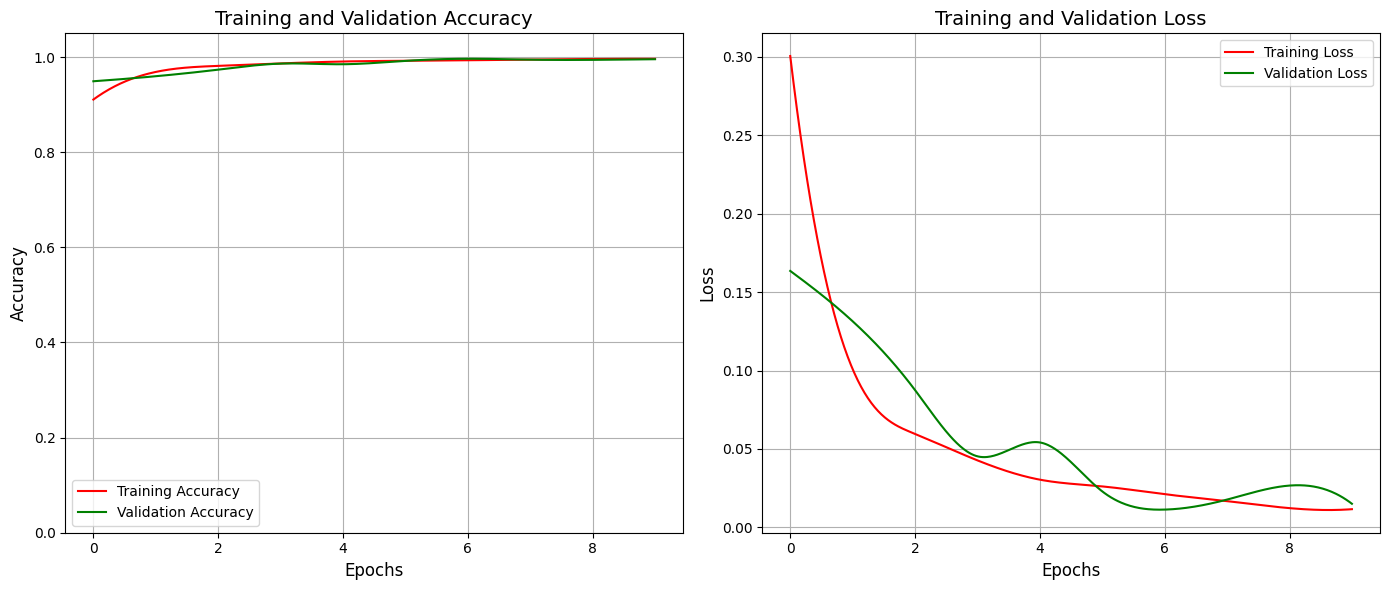

In [ ]:
train_acc_finetune = history_finetune.history['accuracy']
val_acc_finetune = history_finetune.history['val_accuracy']
train_loss_finetune = history_finetune.history['loss']
val_loss_finetune = history_finetune.history['val_loss']
epochs_finetune = range(len(train_acc_finetune))

plot_learning_curves(epochs_finetune, train_acc_finetune, val_acc_finetune, train_loss_finetune, val_loss_finetune, 'Fine-Tuning-MobileNetV2-Accuracy-Loss.png')

In [ ]:
file_path = 'Fine-Tuning-MobileNetV2-Accuracy-Loss.png'

destination_path = '/content/drive/My Drive/' + file_path
shutil.move(file_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/Fine-Tuning-MobileNetV2-Accuracy-Loss.png


# Plot Accuracy and Loss Combined

In [ ]:
def plot_combined_learning_curves(
    transfer_epochs, transfer_train_acc, transfer_val_acc, transfer_train_loss, transfer_val_loss,
    finetune_epochs, finetune_train_acc, finetune_val_acc, finetune_train_loss, finetune_val_loss,
    start_fine_tuning_epoch, file_name
):
    combined_epochs = list(transfer_epochs) + [e + max(transfer_epochs) + 1 for e in finetune_epochs]
    combined_train_acc = list(transfer_train_acc) + list(finetune_train_acc)
    combined_val_acc = list(transfer_val_acc) + list(finetune_val_acc)
    combined_train_loss = list(transfer_train_loss) + list(finetune_train_loss)
    combined_val_loss = list(transfer_val_loss) + list(finetune_val_loss)

    x = np.array(combined_epochs)
    x_smooth = np.linspace(x.min(), x.max(), 500)

    train_acc_smooth = make_interp_spline(x, combined_train_acc)(x_smooth)
    val_acc_smooth = make_interp_spline(x, combined_val_acc)(x_smooth)
    train_loss_smooth = make_interp_spline(x, combined_train_loss)(x_smooth)
    val_loss_smooth = make_interp_spline(x, combined_val_loss)(x_smooth)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # Plot Training and Validation Accuracy
    axes[0].plot(x_smooth, train_acc_smooth, label='Training Accuracy', color='blue')
    axes[0].plot(x_smooth, val_acc_smooth, label='Validation Accuracy', color='orange')
    axes[0].axvline(x=start_fine_tuning_epoch, color='green', linestyle='--', label='Start Fine Tuning')
    axes[0].set_title('Training and Validation Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid()

    # Plot Training and Validation Loss
    axes[1].plot(x_smooth, train_loss_smooth, label='Training Loss', color='blue')
    axes[1].plot(x_smooth, val_loss_smooth, label='Validation Loss', color='orange')
    axes[1].axvline(x=start_fine_tuning_epoch, color='green', linestyle='--', label='Start Fine Tuning')
    axes[1].set_title('Training and Validation Loss', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid()

    plt.tight_layout()
    plt.savefig(file_name)
    plt.show()

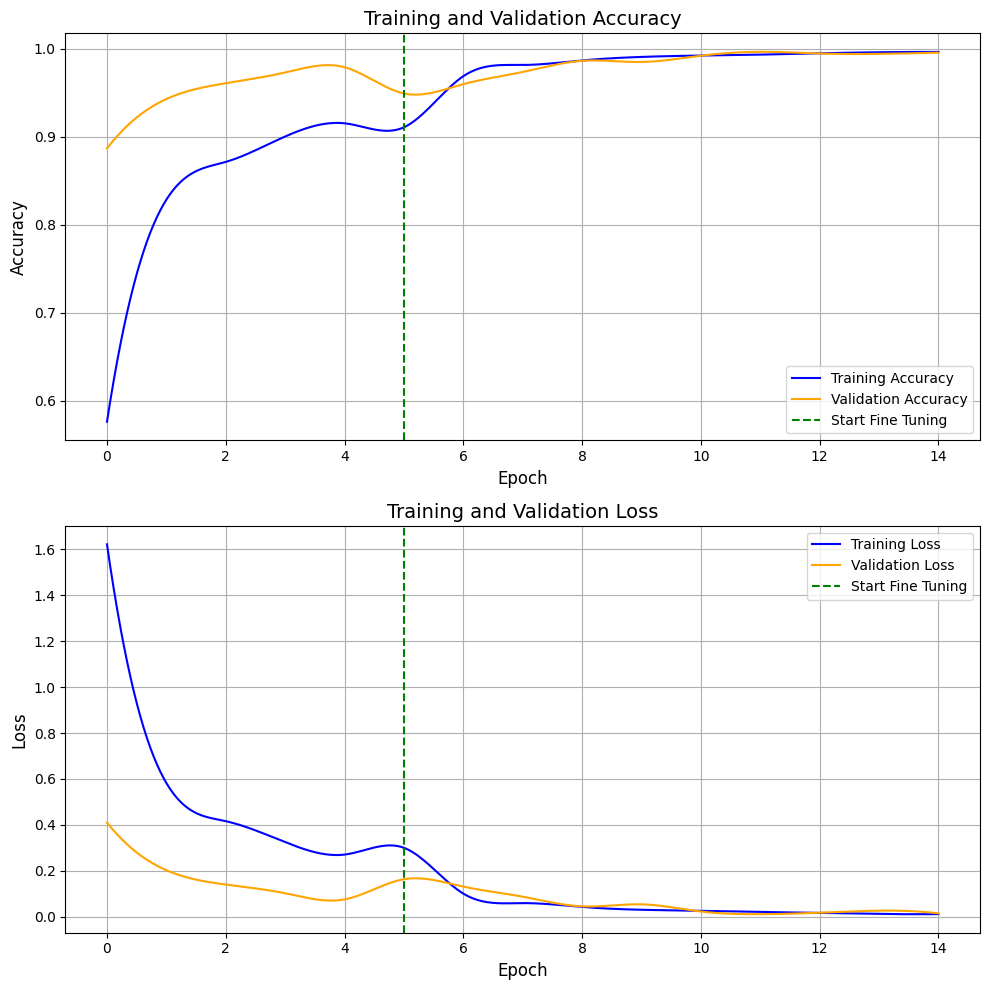

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))

train_acc_finetune = history_finetune.history['accuracy']
val_acc_finetune = history_finetune.history['val_accuracy']
train_loss_finetune = history_finetune.history['loss']
val_loss_finetune = history_finetune.history['val_loss']
epochs_finetune = range(len(train_acc_finetune))

plot_combined_learning_curves(
    epochs, train_acc, val_acc, train_loss, val_loss,
    epochs_finetune, train_acc_finetune, val_acc_finetune, train_loss_finetune, val_loss_finetune,
    len(epochs), 'MobileNetV2-Accuracy-Loss-Combined.png'
)

In [ ]:
file_path = 'MobileNetV2-Accuracy-Loss-Combined.png'

destination_path = '/content/drive/My Drive/' + file_path
shutil.move(file_path, destination_path)

print(f"File successfully moved to Google Drive at: {destination_path}")

File successfully moved to Google Drive at: /content/drive/My Drive/MobileNetV2-Accuracy-Loss-Combined.png


# Evaluation Fine-Tuning Model

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

test_loss, test_acc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 845ms/step - accuracy: 0.9952 - loss: 0.0184
Validation Loss: 0.0151
Validation Accuracy: 0.9956
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 891ms/step - accuracy: 0.9974 - loss: 0.0101
Test Loss: 0.0183
Test Accuracy: 0.9956


# Predict Test Data Fine-Tuning Model

21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 918ms/step


Classification Report

                              precision    recall  f1-score   support

                 Bali_Barong       0.97      1.00      0.99       100
                  Bali_Merak       0.99      1.00      1.00       100
          Jakarta_OndelOndel       1.00      0.98      0.99       100
              Jakarta_Tumpal       1.00      1.00      1.00       100
       JawaBarat_Megamendung       0.96      1.00      0.98       100
        JawaTengah_AsemArang       1.00      1.00      1.00       100
        JawaTengah_AsemSinom       1.00      1.00      1.00       100
        JawaTengah_AsemWarak       1.00      1.00      1.00       100
           JawaTengah_Blekok       1.00      1.00      1.00       100
      JawaTengah_BlekokWarak       1.00      1.00      1.00       100
         JawaTengah_Cipratan       1.00      1.00      1.00       100
JawaTengah_GambangSemarangan       1.00      1.00      1.00       100
       JawaTengah_Ikan

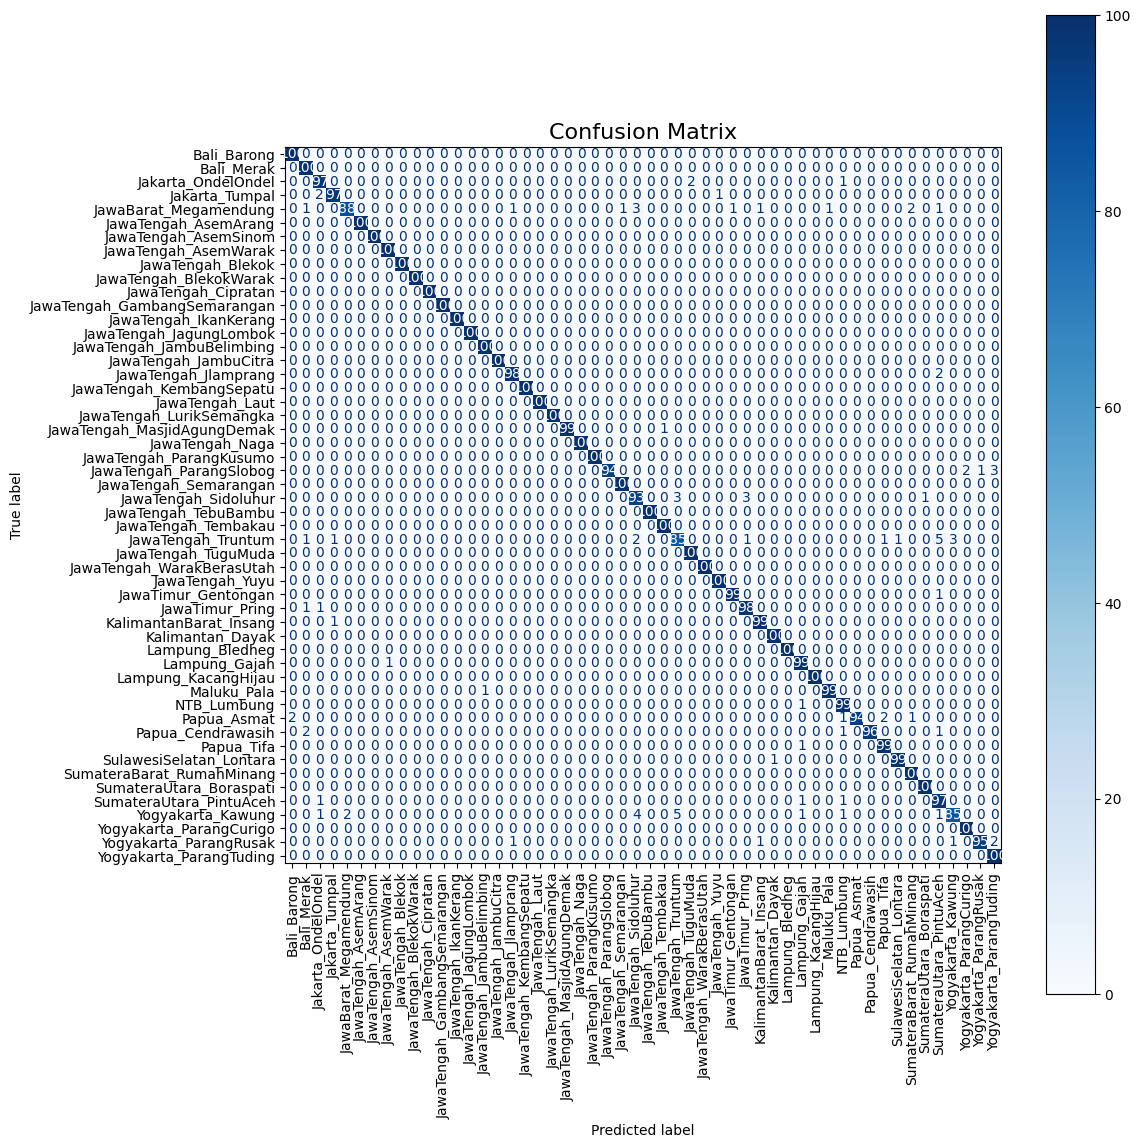

In [ ]:
# Predict
test_generator.reset()
predictions_finetune = model.predict(test_generator)
predicted_classes_finetune = np.argmax(predictions_finetune, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\n\nClassification Report\n")
print(classification_report(true_classes, predicted_classes_finetune, target_names=class_labels))

# Confusion Matrix
print("\nConfusion Matrix\n")
cm_finetune = confusion_matrix(true_classes, predicted_classes_finetune)

# Display Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
disp.ax_.set_title("Confusion Matrix", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
correct_per_class_finetune = np.diag(cm_finetune)
total_per_class_finetune = np.sum(cm_finetune, axis=1)
incorrect_per_class_finetune = total_per_class_finetune - correct_per_class_finetune
accuracy_per_class_finetune = np.round((correct_per_class_finetune / total_per_class_finetune * 100), 2)

results_df_finetune = pd.DataFrame({
    'Category': class_labels,
    'Correct': correct_per_class_finetune,
    'Incorrect': incorrect_per_class_finetune,
    'Accuracy (%)': accuracy_per_class_finetune
})

print(results_df_finetune)

                        Category  Correct  Incorrect  Accuracy (%)
0                    Bali_Barong      100          0         100.0
1                     Bali_Merak      100          0         100.0
2             Jakarta_OndelOndel       98          2          98.0
3                 Jakarta_Tumpal      100          0         100.0
4          JawaBarat_Megamendung      100          0         100.0
5           JawaTengah_AsemArang      100          0         100.0
6           JawaTengah_AsemSinom      100          0         100.0
7           JawaTengah_AsemWarak      100          0         100.0
8              JawaTengah_Blekok      100          0         100.0
9         JawaTengah_BlekokWarak      100          0         100.0
10           JawaTengah_Cipratan      100          0         100.0
11  JawaTengah_GambangSemarangan      100          0         100.0
12         JawaTengah_IkanKerang      100          0         100.0
13       JawaTengah_JagungLombok      100          0         1

# Test Image Prediction

In [ ]:
def predict_image(model, target_size, class_labels):
    def load_and_preprocess_image(img_path, target_size):
        # Load and preprocess the image
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array, img

    print("Upload your images...")
    uploaded = files.upload()

    for img_path in uploaded.keys():
        img_array, img = load_and_preprocess_image(img_path, target_size)
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)
        confidence = prediction[0][predicted_class]

        print(f"Image: {img_path}")
        print(f"Prediction: {class_labels[predicted_class]}")
        print(f"Confidence: {confidence:.2f}")

        # Display the image with prediction
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {class_labels[predicted_class]} (Confidence: {confidence:.2f})")
        plt.show()

target_size = (224, 224)
class_labels = list(test_generator.class_indices.keys())

Upload your images...


Saving Motif-awan-mega-mendung.jpg to Motif-awan-mega-mendung.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: Motif-awan-mega-mendung.jpg
Prediction: JawaBarat_Megamendung
Confidence: 1.00


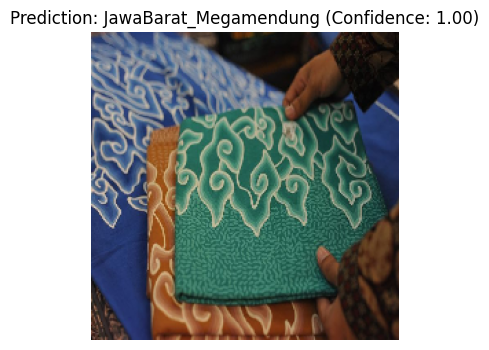

In [ ]:
predict_image(model, target_size, class_labels)

Upload your images...


Saving motif batik ondel ondel.jpg to motif batik ondel ondel.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: motif batik ondel ondel.jpg
Prediction: Jakarta_OndelOndel
Confidence: 1.00


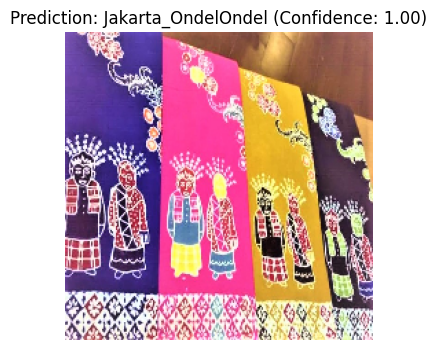

In [ ]:
predict_image(model, target_size, class_labels)

# Convert to TFjs

In [ ]:
model = load_model('final_finetune_mobilenetv2_model.keras')

model.save('final_batiklens_model.h5')

In [ ]:
src_folder = '/content/final_batiklens_model.h5'
dest_folder = '/content/drive/My Drive/BatikLens/final_batiklens_model.h5'

shutil.move(src_folder, dest_folder)

print(f"Folder successfully moved to {dest_folder}")

Folder successfully moved to /content/drive/My Drive/BatikLens/final_batiklens_model.h5


In [ ]:
model_path = '/content/final_batiklens_model.h5'

!tensorflowjs_converter --input_format=keras {model_path} tfjs_model

2024-11-23 22:39:28.610417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732401568.650801    1529 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732401568.663588    1529 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
src_folder = '/content/tfjs_model'
dest_folder = '/content/drive/My Drive/BatikLens/tfjs_model'

shutil.move(src_folder, dest_folder)

print(f"Folder successfully moved to {dest_folder}")

Folder successfully moved to /content/drive/My Drive/BatikLens/tfjs_model
